# Semantic Segmentation

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import zipfile
from sklearn.model_selection import KFold
import os
import matplotlib.pyplot as plt
!pip install rasterio # library for reading and writing geospatial data
import rasterio as rio
from rasterio.transform import xy
import tensorflow as tf


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 82.9 MB/s eta 0:00:00


In [76]:
path_to_drive = '/content/drive/My Drive/'

zip_path = path_to_drive + 'Potsdam-GeoTif.zip'

zip_file = zipfile.ZipFile(zip_path, "r")
file_names = zip_file.namelist()
np.random.shuffle(file_names)

In [7]:
# Get 5000 images from the dataset
image_paths = [f for f in file_names[:5000] if f.endswith(".tif")]

# 5 splits for 5000 images makes
kf = KFold(n_splits=5, shuffle=True, random_state=1)
os.makedirs(path_to_drive + 'folds', exist_ok=True)

# Write tfrecords
for fold_idx, (_, val_idx) in enumerate(kf.split(image_paths)):
    paths = [image_paths[i] for i in val_idx]
    with tf.io.TFRecordWriter(f"{path_to_drive}folds/fold_{fold_idx}.tfrecord") as writer:
        for image_path in paths:
            with zip_file.open(image_path) as f:
                with rio.open(f) as src:
                    assert src.count == 6
                    assert src.width == 224
                    assert src.height == 224
                    image = src.read()
                    image = np.moveaxis(image, 0, -1)
                    image = image.astype(np.uint8)
                image = image.tobytes()
                assert len(image) == 224 * 224 * 6
                example = tf.train.Example(features=tf.train.Features(feature={
                    "image": tf.train.Feature(bytes_list=tf.train.BytesList(value=[image])),
                }))
                writer.write(example.SerializeToString())
    print(f"Fold {fold_idx} done")


Fold 0 done
Fold 1 done
Fold 2 done
Fold 3 done
Fold 4 done


In [50]:
import tensorflow as tf

def parse_example(example_proto, use_elevation):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example_proto, feature_description)
    image = tf.io.decode_raw(example["image"], out_type=tf.uint8)
    image = tf.reshape(image, (224, 224, 6))

    if use_elevation:
      x = image[:, :, :5]
    else:
      x = image[:, :, :4]
    x = tf.cast(x, tf.float32) / 255.0

    y = image[:, :, 5]
    y = tf.one_hot(tf.cast(y, tf.int32), depth=6)

    return x, y

# Flip and rotate image randomly
def augment(x, y):
    if tf.random.uniform(()) > 0.5:
        x = tf.image.flip_left_right(x)
        y = tf.image.flip_left_right(y)
    if tf.random.uniform(()) > 0.5:
        x = tf.image.flip_up_down(x)
        y = tf.image.flip_up_down(y)

    num_rotations = tf.random.uniform([], 0, 4, dtype=tf.int32)
    x = tf.image.rot90(x, k=num_rotations)
    y = tf.image.rot90(y, k=num_rotations)

    return x, y

def load_dataset(batch_size, use_elevation):
    train_files = [f"/content/drive/My Drive/folds/fold_{i}.tfrecord" for i in range(3)]
    val_files = ["/content/drive/My Drive/folds/fold_3.tfrecord"]
    test_files = ["/content/drive/My Drive/folds/fold_4.tfrecord"]

    train_dataset = tf.data.TFRecordDataset(train_files)
    val_dataset   = tf.data.TFRecordDataset(val_files)
    test_dataset  = tf.data.TFRecordDataset(test_files)

    train_dataset = train_dataset.map(lambda example_proto: parse_example(example_proto, use_elevation), num_parallel_calls=tf.data.AUTOTUNE)
    val_dataset = val_dataset.map(lambda example_proto: parse_example(example_proto, use_elevation), num_parallel_calls=tf.data.AUTOTUNE)
    test_dataset = test_dataset.map(lambda example_proto: parse_example(example_proto, use_elevation), num_parallel_calls=tf.data.AUTOTUNE)

    train_dataset = train_dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

    train_dataset = train_dataset.shuffle(1000).batch(batch_size)
    val_dataset = val_dataset.batch(batch_size)
    test_dataset = test_dataset.batch(batch_size)

    train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
    val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)
    test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

    return train_dataset, val_dataset, test_dataset


# Small model without using elevation

In [10]:
import keras
from keras import layers

def build_simple_model(): return keras.Sequential([
    layers.Input(shape=(224, 224, 4)),
    layers.Conv2D(32, 3, activation="relu", padding="same"),
    layers.Conv2D(6, 3, activation="softmax", padding="same")
])

simple_train_dataset, val_dataset, test_dataset = load_dataset(batch_size=32, use_elevation=False)

simple_model = build_simple_model()
simple_model.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])
simple_model_history = simple_model.fit(
    simple_train_dataset,
    validation_data = val_dataset,
    epochs = 20
)


Epoch 1/20
     94/Unknown 13s 75ms/step - accuracy: 0.2244 - loss: 1.6619

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 98ms/step - accuracy: 0.2253 - loss: 1.6607 - val_accuracy: 0.4487 - val_loss: 1.4046
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.4336 - loss: 1.3524 - val_accuracy: 0.4156 - val_loss: 1.2494
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.4549 - loss: 1.2424 - val_accuracy: 0.4705 - val_loss: 1.2114
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.4739 - loss: 1.2222 - val_accuracy: 0.5024 - val_loss: 1.1848
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.5036 - loss: 1.1925 - val_accuracy: 0.5398 - val_loss: 1.1589
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.5227 - loss: 1.1683 - val_accuracy: 0.5418 - val_loss: 1.1353
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.5327 - loss: 1.1488 - val_accuracy: 0.5524 - val_loss: 1.1198
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.5438 - loss: 1.1304 - val_accuracy: 0.5613 - val_loss: 1

In [81]:
x_small, y_small = test_dataset.as_numpy_iterator().next()
y_pred_small = simple_model.predict(x_small)

y_pred_small = np.argmax(y_pred_small, axis=-1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


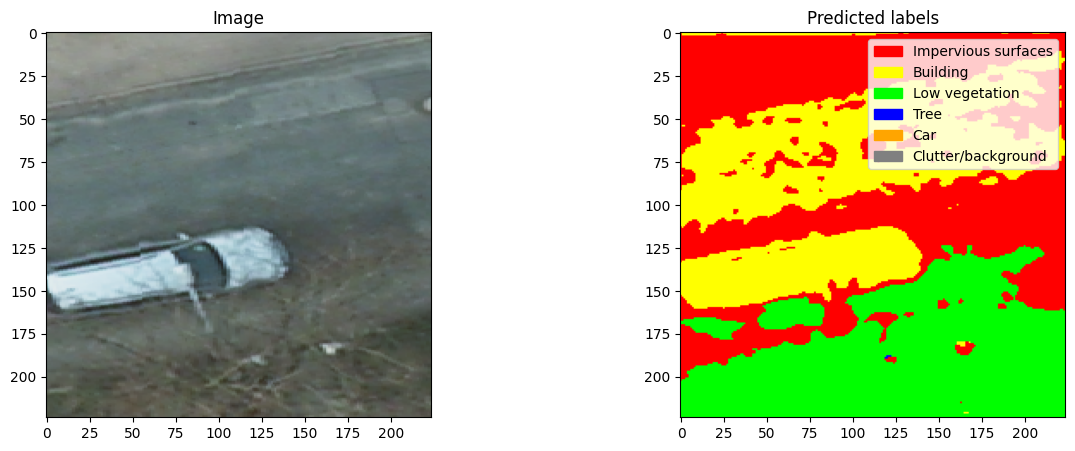

In [83]:
import matplotlib.patches as mpatches

class_colors = np.array([
    [1, 0, 0],
    [1, 1, 0],
    [0, 1, 0],
    [0, 0, 1],
    [1.0, 0.647, 0],
    [0.5, 0.5, 0.5]])

class_names = [
    "Impervious surfaces",
    "Building",
    "Low vegetation",
    "Tree",
    "Car",
    "Clutter/background"]

cmap = plt.cm.colors.ListedColormap(class_colors)

legend_handles = [mpatches.Patch(color=class_colors[i], label=class_names[i]) for i in range(6)]

plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.imshow(x_small[25, :, :, :3])
plt.title("Image")

plt.subplot(1,2,2)
plt.imshow(y_pred_small[25], vmin=0, vmax=5, cmap=cmap)
plt.title("Predicted labels")
plt.legend(handles=legend_handles, loc='upper right')


# Larger model using elevation

In [34]:
def build_big_model():
    input_layer = keras.Input(shape=(224, 224, 5))

    # encoder
    conv_1 = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(input_layer)
    max_pool_1 = layers.MaxPooling2D(pool_size=(2,2))(conv_1)

    conv_2 = layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(max_pool_1)
    max_pool_2 = layers.MaxPooling2D(pool_size=(2,2))(conv_2)

    conv_3 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(max_pool_2)

    # decoder
    conv_transpose_1 = layers.Conv2DTranspose(filters=64, kernel_size=(3,3), activation='relu', padding='same', strides=2)(conv_3)

    concat_1 = layers.Concatenate()([conv_transpose_1, conv_2])
    conv_transpose_2 = layers.Conv2DTranspose(filters=32, kernel_size=(3,3), activation='relu', padding='same', strides=2)(concat_1)

    concat_2 = layers.Concatenate()([conv_transpose_2, conv_1])
    conv_transpose_3 = layers.Conv2DTranspose(filters=32, kernel_size=(3,3), activation='relu', padding='same')(concat_2)

    output_layer = layers.Conv2D(filters=6, kernel_size=(3,3), activation='softmax', padding='same')(conv_transpose_3)

    model = keras.Model(inputs=input_layer, outputs=output_layer)
    return model

In [53]:
big_train_dataset, big_val_dataset, big_test_dataset = load_dataset(batch_size=32, use_elevation=True)

big_model = build_big_model()
big_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
big_model_history = big_model.fit(
    big_train_dataset,
    validation_data = big_val_dataset,
    epochs=20
)

Epoch 1/20
     94/Unknown 43s 286ms/step - accuracy: 0.5303 - loss: 1.3217

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


94/94 ━━━━━━━━━━━━━━━━━━━━ 48s 340ms/step - accuracy: 0.5313 - loss: 1.3192 - val_accuracy: 0.6940 - val_loss: 0.9121
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 194ms/step - accuracy: 0.6902 - loss: 0.8961 - val_accuracy: 0.7091 - val_loss: 0.8289
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 196ms/step - accuracy: 0.7085 - loss: 0.8445 - val_accuracy: 0.7109 - val_loss: 0.8095
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 197ms/step - accuracy: 0.7111 - loss: 0.8253 - val_accuracy: 0.7173 - val_loss: 0.8092
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 198ms/step - accuracy: 0.7163 - loss: 0.7964 - val_accuracy: 0.6834 - val_loss: 0.8447
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 199ms/step - accuracy: 0.7191 - loss: 0.7911 - val_accuracy: 0.7298 - val_loss: 0.7614
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 200ms/step - accuracy: 0.7244 - loss: 0.7656 - val_accuracy: 0.7329 - val_loss: 0.7423
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 200ms/step - accuracy: 0.7355 - loss: 0.7363 - val_accuracy: 0.743

In [84]:
x_big, y_big = big_test_dataset.as_numpy_iterator().next()
y_pred_big = big_model.predict(x)

y_pred_big = np.argmax(y_pred_big, axis=-1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


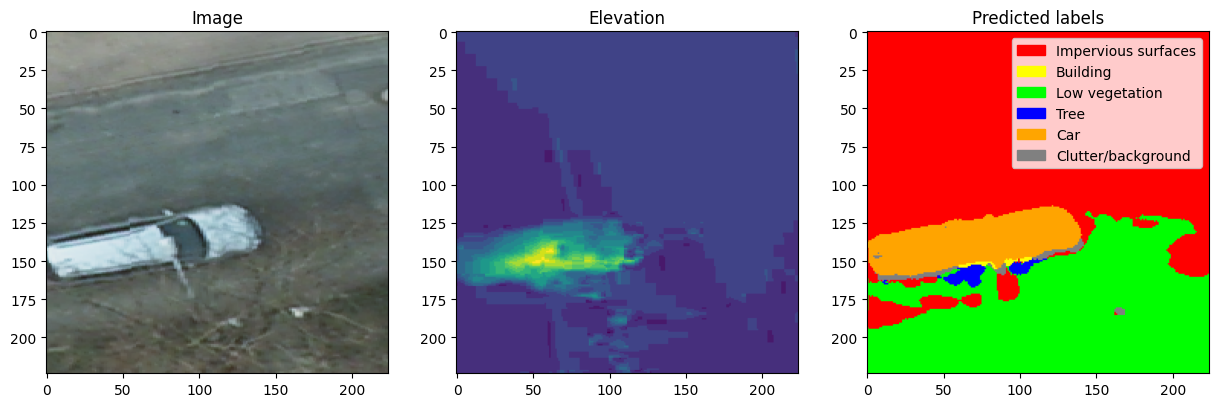

In [85]:
plt.figure(figsize = (15,5))

plt.subplot(1,3,1)
plt.imshow(x_big[25, :, :, :3])
plt.title("Image")

plt.subplot(1,3,2)
plt.imshow(x_big[25, :, :, 4])
plt.title("Elevation")

plt.subplot(1,3,3)
plt.imshow(y_pred_big[25], vmin=0, vmax=5, cmap=cmap)
plt.title("Predicted labels")
plt.legend(handles=legend_handles, loc='upper right')